# Project: Used Car Price Prediction (End-to-End)

**Goal**: Build a Machine Learning model to accurately predict the selling price of a car based on its features (Manufacturer, Mileage, Engine, etc.).

## Initial Setup
Importing the libraries

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Sklearn Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline

# Sklearn Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge

# Metrics & Saving
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

# Visualization Config
plt.style.use('ggplot')
sns.set_context('notebook')
pd.set_option('display.max_columns', None)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print("Libraries Loaded Successfully")

Libraries Loaded Successfully


## Data Cleaning & Exploratory Data Analysis

In [2]:
file_name = '/kaggle/input/car-price-prediction-challenge/car_price_prediction.csv'
df = pd.read_csv(file_name)

In [3]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [4]:
df.shape

(19237, 18)

In [5]:
df.describe()

,ID,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

### Inspecting messy columns

In [8]:
print("Levy samples:", df['Levy'].unique()[:5])
print("Engine samples:", df['Engine volume'].unique()[:15])
print("Mileage samples:", df['Mileage'].unique()[:5])
print("Doors samples:", df['Doors'].unique())

Levy samples: ['1399' '1018' '-' '862' '446']
Engine samples: ['3.5' '3' '1.3' '2.5' '2' '1.8' '2.4' '4' '1.6' '3.3' '2.0 Turbo'
 '2.2 Turbo' '4.7' '1.5' '4.4']
Mileage samples: ['186005 km' '192000 km' '200000 km' '168966 km' '91901 km']
Doors samples: ['04-May' '02-Mar' '>5']


## Custom Cleaning Functions

In [16]:
def clean_levy(x):
    """
    Replaces '-' with 0 and converts to integer.
    """
    if x =='-':
        return 0
    return int(x)

def clean_mileage(x):
    """
    Removes 'km' and whitespace, converts to integer.
    """
    return int(x.replace('km','').replace(' ',''))

def clean_doors(x):
    """
    Fixes Excel formatting errors in the Doors column.
    """
    x=str(x)
    if '04' in x: return 4
    if '02' in x: return 2
    if '>5' in x: return 5
    return int(x)

def process_engine(df):
    """
    1. Extracts the numerical volume
    2. Creates a new binary feature 'Is_Turbo'
    """

    df['Is_Turbo'] = df['Engine volume'].str.contains('Turbo').astype(int)
    df['Engine_Vol'] = df['Engine volume'].str.extract(r'(\d+\.\d+)').astype(float)

    return df

In [17]:
# Apply simple functions
df['Levy'] = df['Levy'].apply(clean_levy)
df['Mileage'] = df['Mileage'].apply(clean_mileage)
df['Doors'] = df['Doors'].apply(clean_doors)

# Apply Engine logic
df = process_engine(df)

# Drop redundant ID and original Engine column
df = df.drop(['ID', 'Engine volume'], axis=1)

df.head()

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Is_Turbo,Engine_Vol
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,186005,6.0,Automatic,4x4,4,Left wheel,Silver,12,0,3.5
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,192000,6.0,Tiptronic,4x4,4,Left wheel,Black,8,0,NaN
2,8467,0,HONDA,FIT,2006,Hatchback,No,Petrol,200000,4.0,Variator,Front,4,Right-hand drive,Black,2,0,1.3
3,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,168966,4.0,Automatic,4x4,4,Left wheel,White,0,0,2.5
4,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,91901,4.0,Automatic,Front,4,Left wheel,Silver,4,0,1.3


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             19237 non-null  int64  
 1   Levy              19237 non-null  int64  
 2   Manufacturer      19237 non-null  object 
 3   Model             19237 non-null  object 
 4   Prod. year        19237 non-null  int64  
 5   Category          19237 non-null  object 
 6   Leather interior  19237 non-null  object 
 7   Fuel type         19237 non-null  object 
 8   Mileage           19237 non-null  int64  
 9   Cylinders         19237 non-null  float64
 10  Gear box type     19237 non-null  object 
 11  Drive wheels      19237 non-null  object 
 12  Doors             19237 non-null  int64  
 13  Wheel             19237 non-null  object 
 14  Color             19237 non-null  object 
 15  Airbags           19237 non-null  int64  
 16  Is_Turbo          19237 non-null  int64 

## Handling Missing Data

In [20]:
# Find the sum of missing values for each column
df.isna().sum()

Price                  0
Levy                   0
Manufacturer           0
Model                  0
Prod. year             0
Category               0
Leather interior       0
Fuel type              0
Mileage                0
Cylinders              0
Gear box type          0
Drive wheels           0
Doors                  0
Wheel                  0
Color                  0
Airbags                0
Is_Turbo               0
Engine_Vol          5048
dtype: int64

In [22]:
# Fill missing values with the median of their Category
df['Engine_Vol'] = df['Engine_Vol'].fillna(df.groupby('Category')['Engine_Vol'].transform('median'))

# If any are still missing, fill with global median
df['Engine_Vol'] = df['Engine_Vol'].fillna(df['Engine_Vol'].median())

print(f"Missing Engine Vol after fix: {df['Engine_Vol'].isnull().sum()}")

Missing Engine Vol after fix: 0


## Distribution Analysis & Feature Engineering

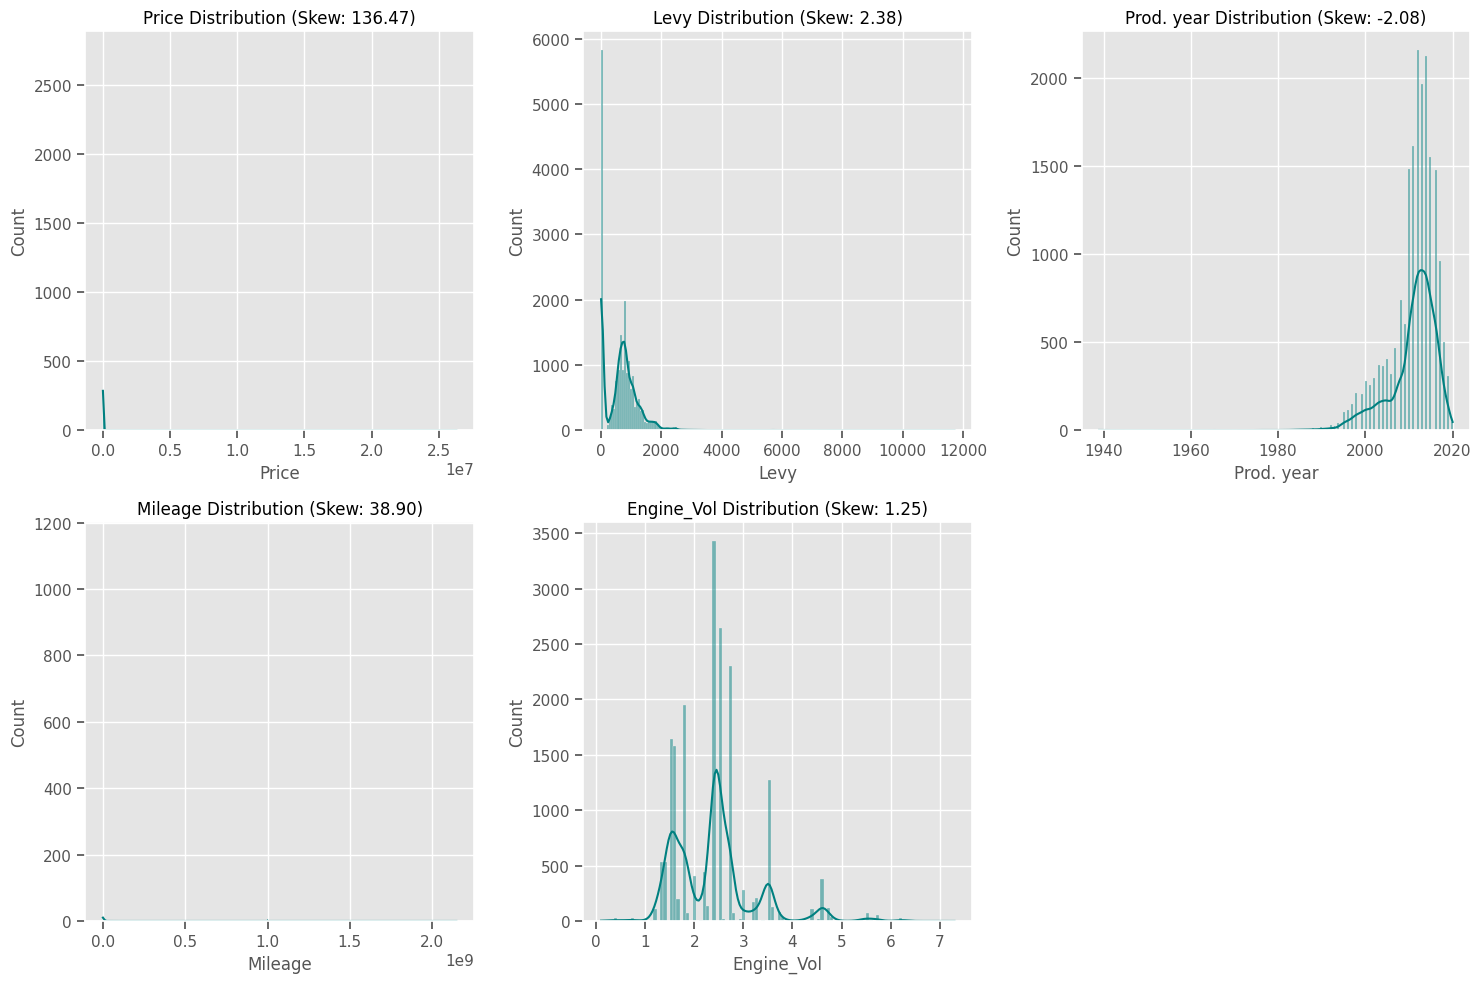

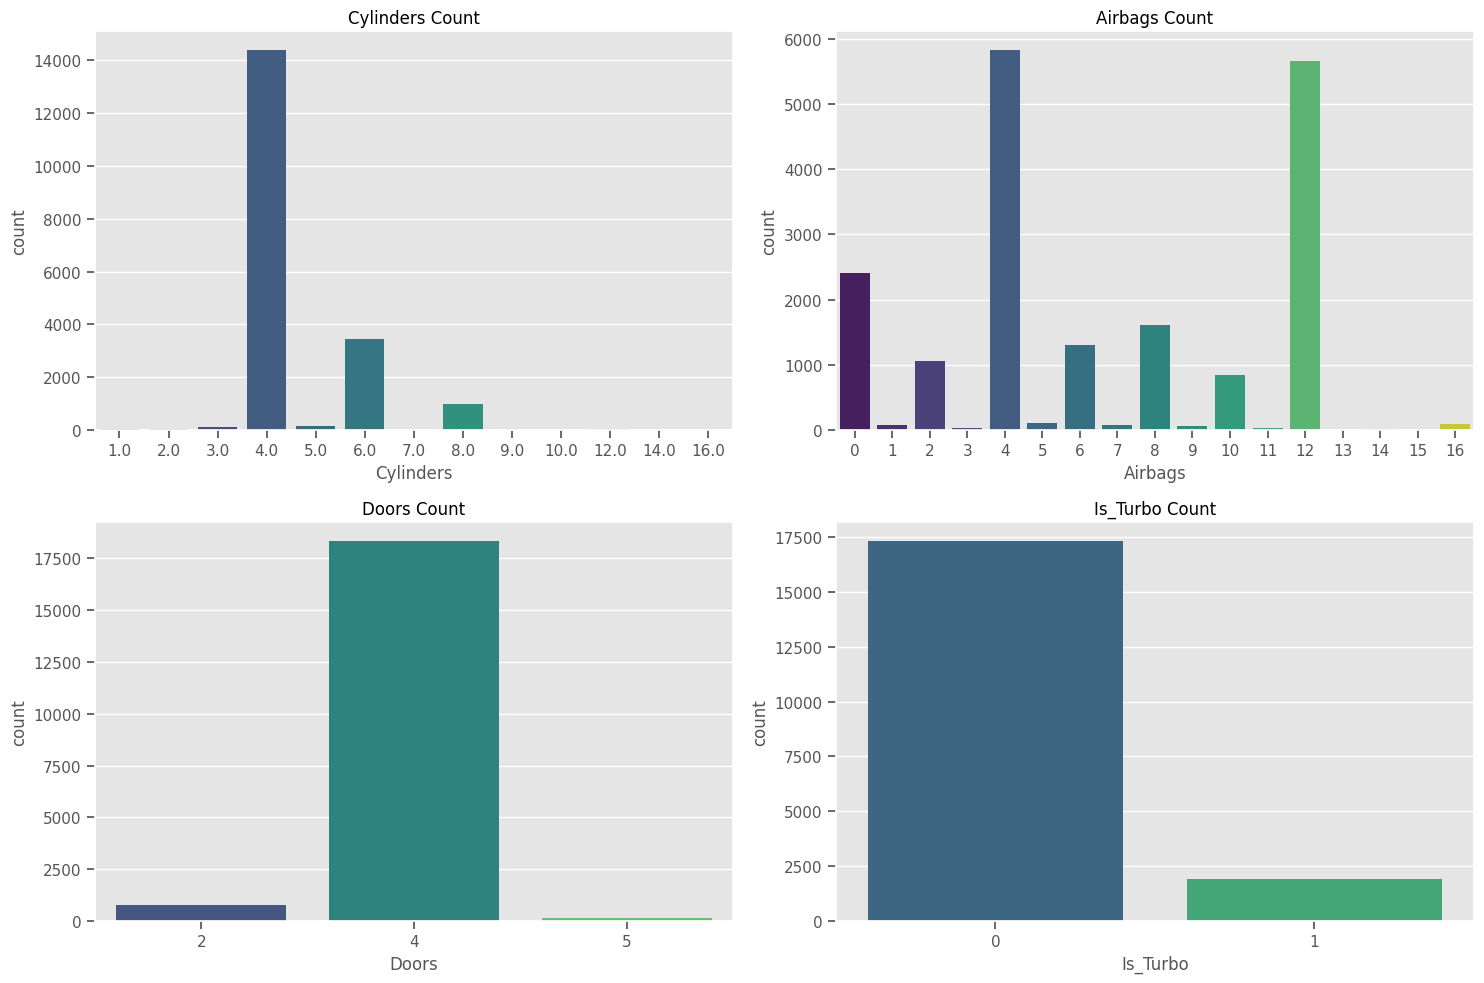

In [24]:
# Identify all numerical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()

# Define discrete columns (few unique values) vs continuous
discrete_cols = ['Cylinders', 'Airbags', 'Doors', 'Is_Turbo']
continuous_cols = [col for col in num_cols if col not in discrete_cols]

# Plot Continuous Variables (Histograms to check Skew)
plt.figure(figsize=(15, 10))
for i, col in enumerate(continuous_cols):
    plt.subplot(2, 3, i+1) # Adjust grid size as needed
    sns.histplot(df[col], kde=True, color='teal')
    plt.title(f'{col} Distribution (Skew: {df[col].skew():.2f})')
plt.tight_layout()
plt.show()

# Plot Discrete Variables (Countplots)
plt.figure(figsize=(15, 10))
for i, col in enumerate(discrete_cols):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=col, data=df, palette='viridis')
    plt.title(f'{col} Count')
plt.tight_layout()
plt.show()

In [25]:
# Create 'Age' (The Depreciator)
current_year = 2025
df['Age'] = current_year - df['Prod. year']
df.drop('Prod. year', axis=1, inplace=True)

# Create 'Km_per_Year' (The Usage Intensity)
# Add 1 to Age to avoid division by zero errors for brand new cars
df['Km_per_Year'] = df['Mileage'] / (df['Age'] + 1)

df.head(2)

,Price,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Is_Turbo,Engine_Vol,Age,Km_per_Year
0,13328,1399,LEXUS,RX 450,Jeep,Yes,Hybrid,186005,6.0,Automatic,4x4,4,Left wheel,Silver,12,0,3.5,15,11625.3125
1,16621,1018,CHEVROLET,Equinox,Jeep,No,Petrol,192000,6.0,Tiptronic,4x4,4,Left wheel,Black,8,0,2.7,14,12800.0000


In [27]:
brand_counts = df['Manufacturer'].value_counts(normalize=True)
print(brand_counts)

Manufacturer
HYUNDAI          0.195925
TOYOTA           0.190362
MERCEDES-BENZ    0.107917
FORD             0.057753
CHEVROLET        0.055570
                   ...   
TESLA            0.000052
PONTIAC          0.000052
SATURN           0.000052
ASTON MARTIN     0.000052
GREATWALL        0.000052
Name: proportion, Length: 65, dtype: float64


In [28]:
# Rare Label Encoding (Handling 65 Manufacturers)
# Solution: Group any brand with < 1% market share into 'Other'.
rare_brands = brand_counts[brand_counts < 0.01].index

print(f"Grouping {len(rare_brands)} rare brands into 'Other'...")
df['Manufacturer'] = df['Manufacturer'].replace(rare_brands, 'Other')


Grouping 49 rare brands into 'Other'...


In [29]:
# Log Transformations (Fixing the Skew we found)
# We use log1p (log(x+1)) because Levy can be 0.
df['Log_Price'] = np.log1p(df['Price'])
df['Log_Levy'] = np.log1p(df['Levy'])
df['Log_Mileage'] = np.log1p(df['Mileage'])

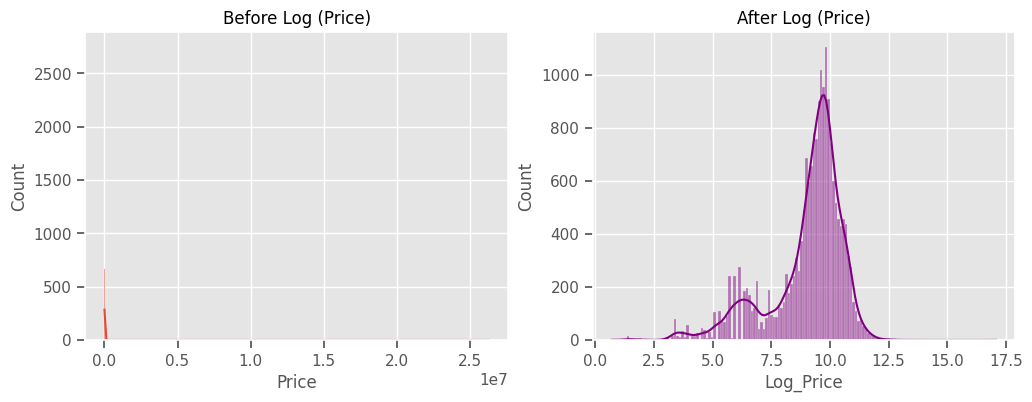

In [31]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['Price'], kde=True)
plt.title('Before Log (Price)')
plt.subplot(1, 2, 2)
sns.histplot(df['Log_Price'], kde=True, color='purple')
plt.title('After Log (Price)')
plt.show()

In [36]:
# 1. Drop the "Poisoned" Log Columns (We will recreate them AFTER cleaning)
cols_to_drop = ['Log_Price', 'Log_Levy', 'Log_Mileage']
df = df.drop(columns=cols_to_drop, errors='ignore')

# 2. Drop 'Model' (Too messy/High Cardinality)
df = df.drop(columns=['Model'], errors='ignore')

In [37]:
df.head(2)

,Price,Levy,Manufacturer,Category,Leather interior,Fuel type,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Is_Turbo,Engine_Vol,Age,Km_per_Year
0,13328,1399,LEXUS,Jeep,Yes,Hybrid,186005,6.0,Automatic,4x4,4,Left wheel,Silver,12,0,3.5,15,11625.3125
1,16621,1018,CHEVROLET,Jeep,No,Petrol,192000,6.0,Tiptronic,4x4,4,Left wheel,Black,8,0,2.7,14,12800.0000


## Outlier Detection and Handling

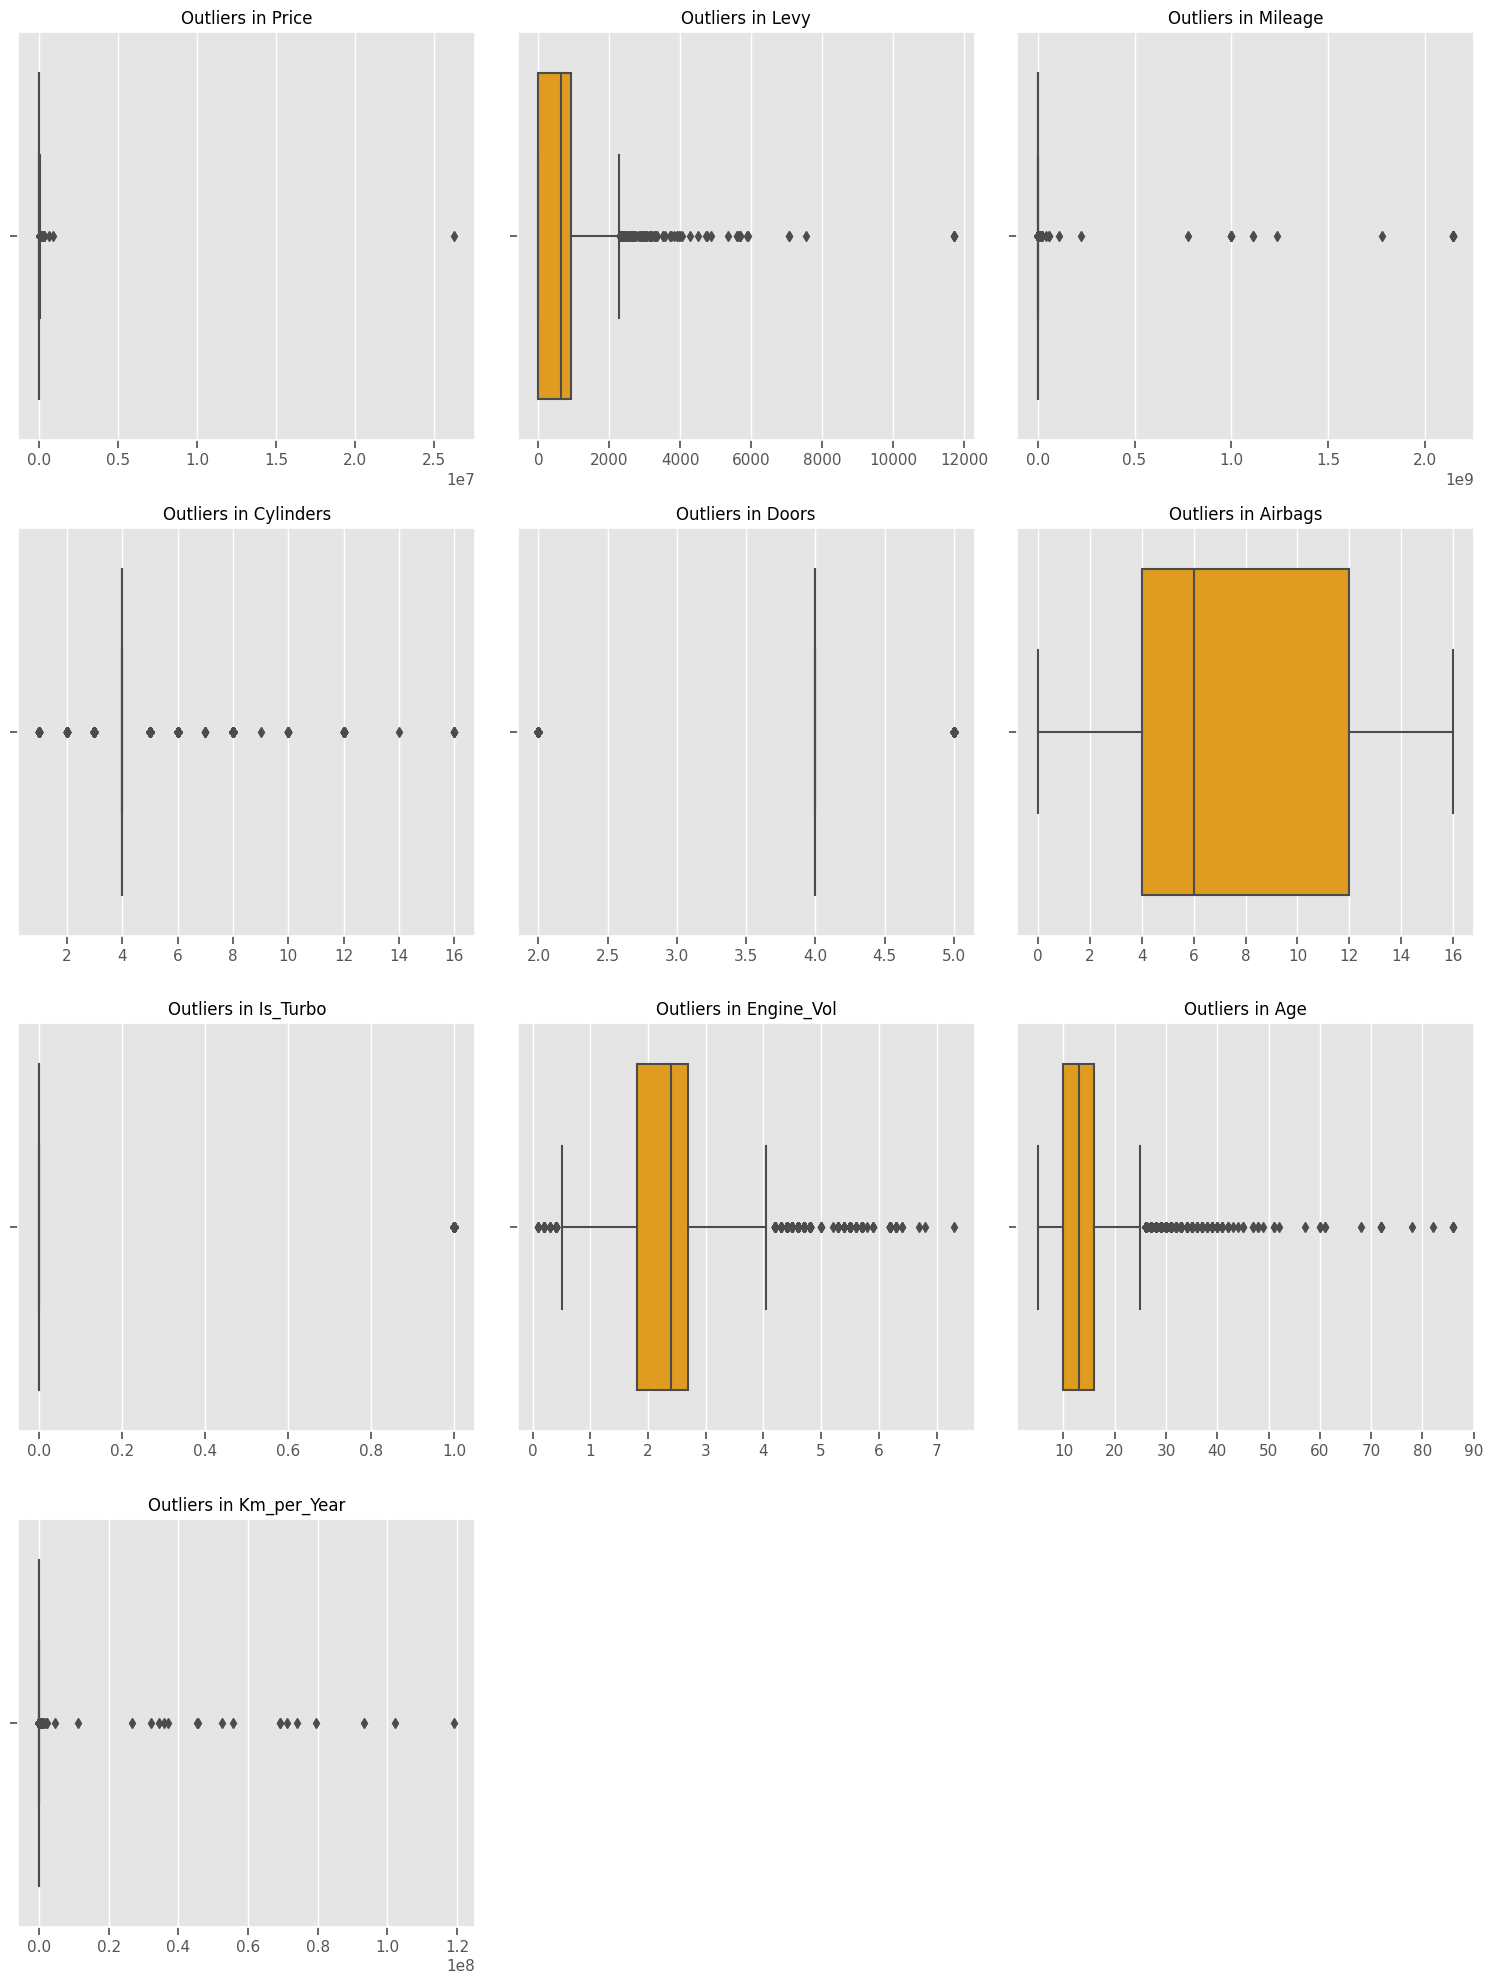

In [38]:
import math

# 1. Identify all numerical columns
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'ID' in numerical_cols:
    numerical_cols.remove('ID')

# 2. Setup the Grid for Subplots
num_plots = len(numerical_cols)
cols = 3  # Number of plots per row
rows = math.ceil(num_plots / cols)

# 3. Generate the Boxplots
plt.figure(figsize=(15, 5 * rows))  # Adjust height dynamically based on rows

for i, col in enumerate(numerical_cols):
    plt.subplot(rows, cols, i + 1)
    
    # Create Boxplot
    sns.boxplot(x=df[col], color='orange')
    
    plt.title(f'Outliers in {col}')
    plt.xlabel('') # Remove x-label to keep it clean

plt.tight_layout()
plt.show()

In [39]:
# REMOVING OUTLIERS

print(f"Row count before filtering: {df.shape[0]}")

# Rule 1: Price
# - Remove cars < $500 (Likely 'junk' or errors)
# - Remove cars > $300,000 (Supercars usually don't fit general pricing models)
df = df[(df['Price'] > 500) & (df['Price'] < 300000)]

# Rule 2: Mileage
# - Remove cars with > 600,000 km (Likely taxi cabs or data entry errors)
df = df[df['Mileage'] < 600000]

# Rule 3: Levy
# - Levy is a tax. It cannot be extremely high relative to price. 
# - We filter out extreme values > 5000 (based on your boxplot visuals)
df = df[df['Levy'] < 5000]

# Rule 4: Cylinders
# - Remove anything > 12 (Likely data errors like '16' unless it's a Bugatti)
df = df[df['Cylinders'] <= 12]

print(f"Row count after filtering:  {df.shape[0]}")
print(f"Dropped {19237 - df.shape[0]} rows of garbage data.")

Row count before filtering: 19237
Row count after filtering:  17396
Dropped 1841 rows of garbage data.


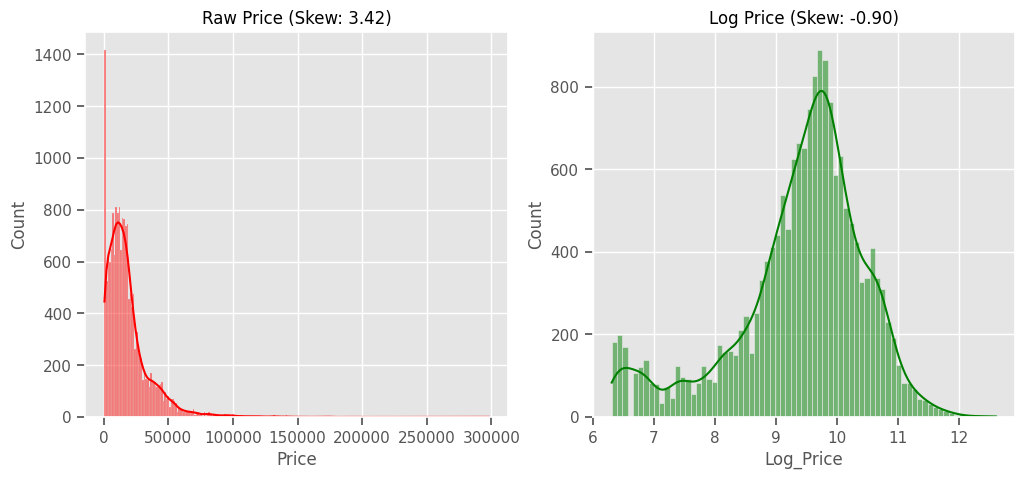

In [40]:
# RE-CREATING LOG FEATURES

# Now we calculate logs on the CLEAN data
# We use log1p (log(x+1)) to handle zeros safely
df['Log_Price'] = np.log1p(df['Price'])
df['Log_Levy'] = np.log1p(df['Levy'])
df['Log_Mileage'] = np.log1p(df['Mileage'])

# Visual Check: Compare Raw vs Log Price
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Price'], kde=True, color='red')
plt.title(f"Raw Price (Skew: {df['Price'].skew():.2f})")

plt.subplot(1, 2, 2)
sns.histplot(df['Log_Price'], kde=True, color='green')
plt.title(f"Log Price (Skew: {df['Log_Price'].skew():.2f})")

plt.show()

In [52]:
df.columns

Index(['ID', 'Price', 'Levy', 'Manufacturer', 'Category', 'Leather interior',
       'Fuel type', 'Engine volume', 'Mileage', 'Cylinders', 'Gear box type',
       'Drive wheels', 'Doors', 'Wheel', 'Color', 'Airbags', 'Is_Turbo',
       'Engine_Vol', 'Age', 'Km_per_Year', 'Model_Grouped', 'Log_Price',
       'Log_Levy', 'Log_Mileage'],
      dtype='object')

### DEFINING X and y

In [53]:
cols_to_drop = ['Price', 'Log_Price', 'Levy', 'Mileage']
X = df.drop(cols_to_drop, axis=1)

In [54]:
y = df['Log_Price']

In [55]:
# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Features: {X_train.shape[1]} columns")
print(f"Features in X: {X.columns.tolist()}")

Training Features: 20 columns
Features in X: ['ID', 'Manufacturer', 'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color', 'Airbags', 'Is_Turbo', 'Engine_Vol', 'Age', 'Km_per_Year', 'Model_Grouped', 'Log_Levy', 'Log_Mileage']


## Preprocessing Pipeline Construction

In [56]:
categorical_features = ['Manufacturer', 'Model_Grouped', 'Category', 'Leather interior', 'Fuel type', 
                        'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color']

numerical_features = ['Log_Levy', 'Log_Mileage', 'Cylinders', 'Airbags', 
                      'Is_Turbo', 'Engine_Vol', 'Age', 'Km_per_Year']

# Build Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ])

print("Pipeline Updated with Model Grouping.")

Pipeline Updated with Model Grouping.


## Model Battle

In [57]:
models = {
    "Ridge Regression": Ridge(solver='lsqr'),
    "Random Forest   ": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boost  ": GradientBoostingRegressor(random_state=42)
}

results = {}
print("Starting Training on Log-Transformed Data...\n")

for name, model in models.items():
    # 1. Create Pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # 2. Train on Log Prices
    pipe.fit(X_train, y_train)
    
    # 3. Predict (Result is still in Log scale)
    y_pred_log = pipe.predict(X_test)
    
    # 4. Convert Back to Real Prices ($) for Evaluation
    y_test_real = np.expm1(y_test)
    y_pred_real = np.expm1(y_pred_log)
    
    # 5. Score
    r2 = r2_score(y_test_real, y_pred_real)
    mae = mean_absolute_error(y_test_real, y_pred_real)
    
    results[name] = r2
    print(f"{name} -> R2 Score: {r2:.4f} | MAE: ${mae:.0f}")

# Visualize the Winner
best_model = max(results, key=results.get)
print(f"The Winner is: {best_model}")

Starting Training on Log-Transformed Data...

Ridge Regression -> R2 Score: 0.3195 | MAE: $8609
Random Forest    -> R2 Score: 0.7360 | MAE: $4201
Gradient Boost   -> R2 Score: 0.5307 | MAE: $6595
The Winner is: Random Forest   


In [ ]:
# final_model = best_model  # Or whatever variable name your winner has

# # 2. Save it to a file
# joblib.dump(final_model, 'car_price_model.pkl')
# print("Model saved as 'car_price_model.pkl'.")